In [1]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

2025-06-16 14:32:27.827564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X_train = joblib.load('../../preprocessed_data/CICIDS/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIDS/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIDS/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIDS/Y_test.joblib')

### CNN training

In [3]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.3), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 33, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 32)            0         
                                                                 
 flatten (Flatten)           (None, 1056)              0         
                                                                 
 dense (Dense)               (None, 64)                67648     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

2025-06-16 14:32:31.508119: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546899520 exceeds 10% of free system memory.


30958/30962 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9594

2025-06-16 14:33:36.659790: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234385548 exceeds 10% of free system memory.


30962/30962 [==============================] - 74s 2ms/step - loss: 0.0995 - accuracy: 0.9594 - val_loss: 0.0712 - val_accuracy: 0.9685
Epoch 2/5
30962/30962 [==============================] - 72s 2ms/step - loss: 0.0804 - accuracy: 0.9655 - val_loss: 0.0678 - val_accuracy: 0.9688
Epoch 3/5
30962/30962 [==============================] - 69s 2ms/step - loss: 0.0797 - accuracy: 0.9667 - val_loss: 0.0656 - val_accuracy: 0.9697
Epoch 4/5
30962/30962 [==============================] - 78s 3ms/step - loss: 0.0755 - accuracy: 0.9675 - val_loss: 0.0660 - val_accuracy: 0.9703
Epoch 5/5
30962/30962 [==============================] - 76s 2ms/step - loss: 0.0753 - accuracy: 0.9680 - val_loss: 0.0637 - val_accuracy: 0.9726


### LSTM training

In [4]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3


2025-06-16 14:38:41.735850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546899520 exceeds 10% of free system memory.


30961/30962 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9493

2025-06-16 14:47:35.050378: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234385548 exceeds 10% of free system memory.


30962/30962 [==============================] - 621s 20ms/step - loss: 0.1227 - accuracy: 0.9493 - val_loss: 0.0900 - val_accuracy: 0.9629
Epoch 2/3
30962/30962 [==============================] - 635s 21ms/step - loss: 0.0766 - accuracy: 0.9679 - val_loss: 0.0685 - val_accuracy: 0.9708
Epoch 3/3
30962/30962 [==============================] - 610s 20ms/step - loss: 0.0698 - accuracy: 0.9707 - val_loss: 0.0626 - val_accuracy: 0.9730


### AE-LSTM

In [5]:
input_dim = X_train.shape[1]  # n_features

# encoder
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 69, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65    

2025-06-16 15:09:49.594305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546899520 exceeds 10% of free system memory.


30962/30962 [==============================] - 637s 21ms/step - loss: 0.1183 - accuracy: 0.9506 - val_loss: 0.0820 - val_accuracy: 0.9653
Epoch 2/3
30962/30962 [==============================] - 625s 20ms/step - loss: 0.0837 - accuracy: 0.9644 - val_loss: 0.0800 - val_accuracy: 0.9682
Epoch 3/3
30962/30962 [==============================] - 602s 19ms/step - loss: 0.0745 - accuracy: 0.9682 - val_loss: 0.0676 - val_accuracy: 0.9734


In [6]:
CNN_model.save("../../models/cnn_CICIDS2017_model.keras")
LSTM_model.save("../../models/lstm_CICIDS2017_model.keras")
AE_LSTM_model.save("../../models/ae-lstm_CICIDS2017_model.keras")

In [7]:
import pickle

In [8]:
file_name_cnn = '../../models/cnn_CICIDS2017.pkl' 
joblib.dump(CNN_model, file_name_cnn) 

file_name_lstm = '../../models/lstm_CICIDS2017.pkl' 
joblib.dump(LSTM_model, file_name_lstm) 

file_name_ae_lstm = '../../models/ae-lstm_CICIDS2017.pkl' 
joblib.dump(AE_LSTM_model, file_name_ae_lstm)

['../../models/ae-lstm_CICIDS2017.pkl']

### CNN metrics

26539/26539 [==============================] - 16s 603us/step
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98    682324
     Attacks       0.91      0.95      0.93    166899

    accuracy                           0.97    849223
   macro avg       0.95      0.97      0.96    849223
weighted avg       0.97      0.97      0.97    849223



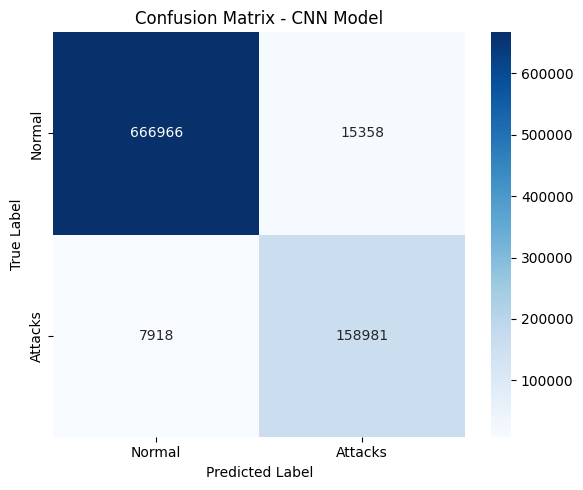

Attacks detected (True Positive) : 158981
Normal traffic detected (True Negative) : 666966
Attacks missed (False Negative) : 7918
False alarms (False Positive) : 15358


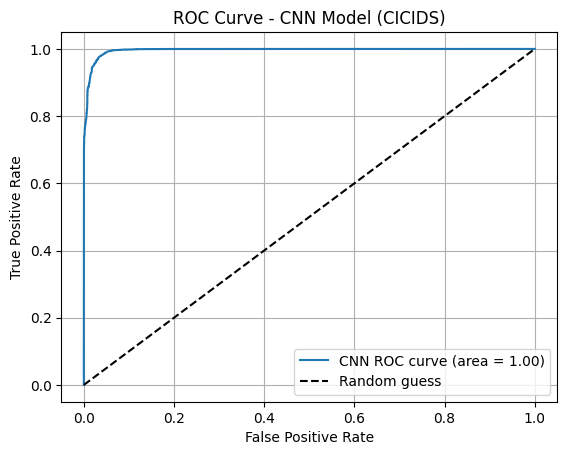

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (CICIDS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### LSTM metrics

26539/26539 [==============================] - 127s 5ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98    682324
     Attacks       0.94      0.93      0.93    166899

    accuracy                           0.97    849223
   macro avg       0.96      0.96      0.96    849223
weighted avg       0.97      0.97      0.97    849223



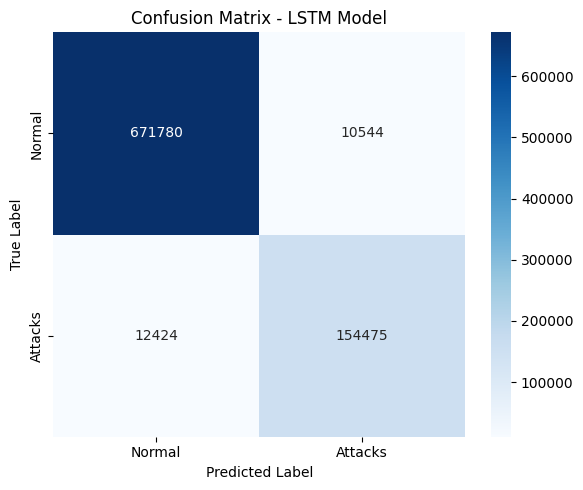

Attacks detected (True Positive) : 154475
Normal traffic detected (True Negative) : 671780
Attacks missed (False Negative) : 12424
False alarms (False Positive) : 10544


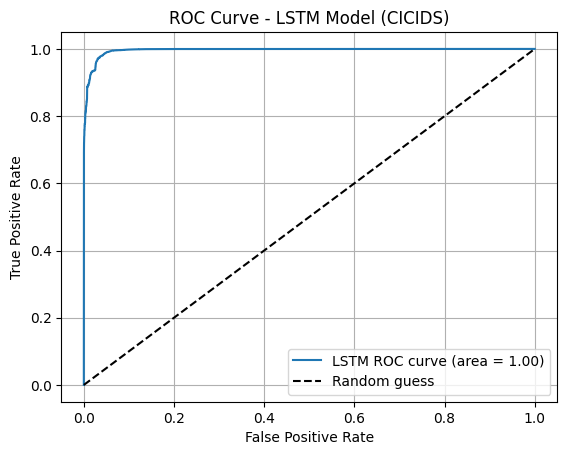

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (CICIDS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### AE-LSTM metrics

26539/26539 [==============================] - 126s 5ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98    682324
     Attacks       0.95      0.91      0.93    166899

    accuracy                           0.97    849223
   macro avg       0.96      0.95      0.96    849223
weighted avg       0.97      0.97      0.97    849223



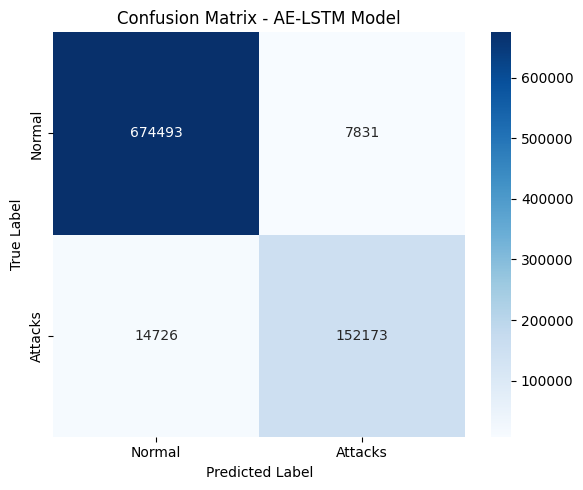

Attacks detected (True Positive) : 152173
Normal traffic detected (True Negative) : 674493
Attacks missed (False Negative) : 14726
False alarms (False Positive) : 7831


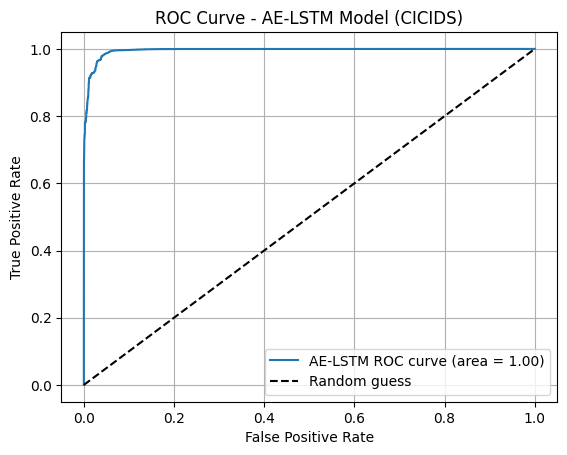

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (CICIDS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
